# Data Science & LLM Technical Assessment

For this Assigment, I have been asked to help a clinical data team develop an AI assistant that:
1. Predicts whether a patient will be readmitted to hospital within 30 days
2. Extracts and categorises key information from free-text discharge notes.

Given dataset - Assignment_Data.xlsx

### Task 1 - Predicts whether a patient will be readmitted to hospital within 30 days

In this task, we focus on the structured data part of the given dataset to build a binary classification model that predicts whether a patient will be readmitted within 30 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Assignment_Data.xlsx')

In [3]:
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [4]:
df.columns

Index(['patient_id', 'age', 'gender', 'diagnosis_code',
       'num_previous_admissions', 'medication_type', 'length_of_stay',
       'readmitted_30_days', 'discharge_note'],
      dtype='object')

In [5]:
df.shape

(200, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


The dataset contains 9 features and 200 records.
Out of the 9 features:
 - 4 are categorical
 - 5 are numerical
 - There are no missing values

In [7]:
df.describe()

,patient_id,age,num_previous_admissions,length_of_stay,readmitted_30_days
count,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,53.720000,1.600000,7.865000,0.32500
std,57.879185,21.294574,1.310951,4.134276,0.46955
min,1.000000,20.000000,0.000000,1.000000,0.00000
25%,50.750000,34.000000,1.000000,4.000000,0.00000
50%,100.500000,54.000000,1.000000,8.000000,0.00000
75%,150.250000,73.000000,2.000000,11.000000,1.00000
max,200.000000,89.000000,6.000000,14.000000,1.00000


In [8]:
df.describe(include='object')

,gender,diagnosis_code,medication_type,discharge_note
count,200,200,200,200
unique,2,4,3,10
top,Female,D001,Type B,Discharge after recovery from pneumonia. No co...
freq,107,56,69,25


For the readmission prediction, I have removed columns that don’t influence the outcome directly:
- patient_id: Unique identifier
- discharge_note: Text data used later in Task 2 (NLP section)

In [9]:
df_task1 = df.copy()
df_task1 = df_task1.drop(['patient_id','discharge_note'], axis=1)

Visualizing the distribution of the numerical features to understand their spread

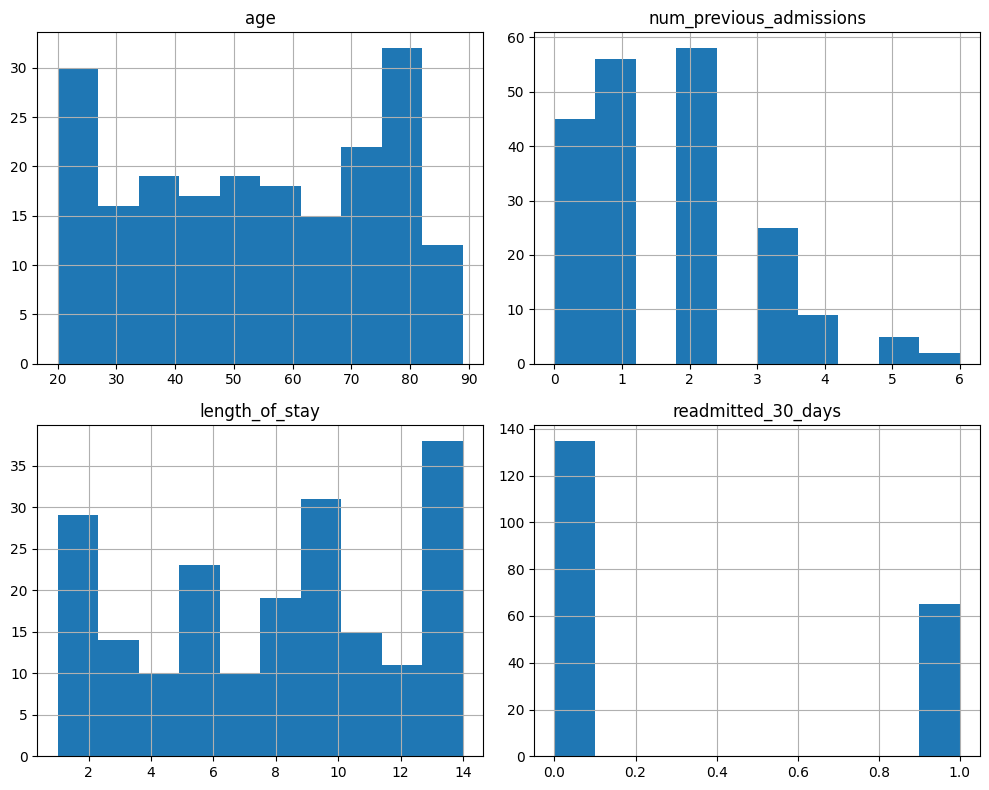

In [10]:
df_task1.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

From the given columns, I have created 2 new features that can give more meaningful relations between the data.
- age_bin: Binned age across 4 groups for easier analysis. Older patients may have higher readmission risk.
- stay_per_admission: Captures how long patients tend to stay relative to their admission history. If a patient has more frequent or longer stays, their readmission risk may increase.

In [11]:
df_task1['age_bin'] = pd.cut(df_task1['age'], bins=[0, 30, 50, 70, 90], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

df_task1['stay_per_admission'] = df_task1.apply(lambda row: row['length_of_stay'] / row['num_previous_admissions'] if row['num_previous_admissions'] > 0 else row['length_of_stay'], axis=1)

df_task1.drop(columns=['age'], inplace=True)

df_task1.head()

,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,age_bin,stay_per_admission
0,Male,D002,3,Type C,2,0,Elderly,0.666667
1,Female,D002,1,Type B,3,1,Middle-aged,3.000000
2,Male,D002,2,Type C,5,1,Elderly,2.500000
3,Female,D002,2,Type C,11,0,Middle-aged,5.500000
4,Female,D001,1,Type C,8,1,Middle-aged,8.000000


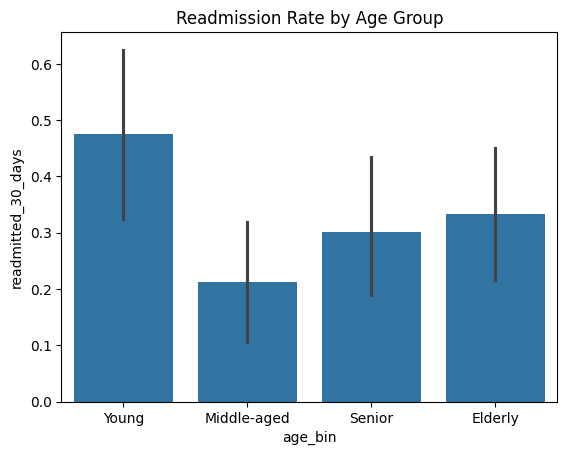

In [12]:
# Readmission by Age
sns.barplot(data=df_task1, x='age_bin', y='readmitted_30_days')
plt.title("Readmission Rate by Age Group")
plt.show()

The above plot shows that young patients tend to have higher readmission rates as opposed to the general assumption of senior and elderly having high readmission rates

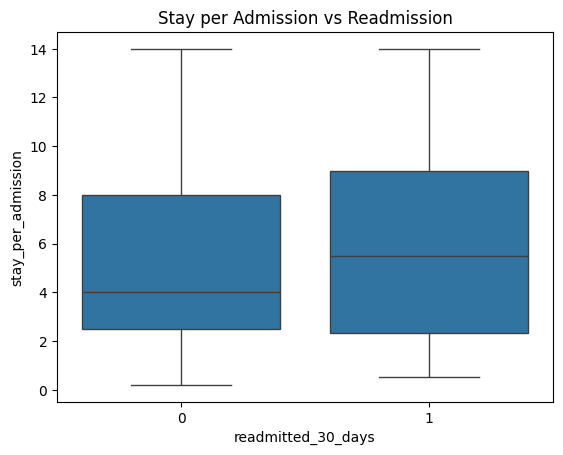

In [13]:
# Readmission by Stay-Per-Admission ratio
sns.boxplot(data=df_task1, x='readmitted_30_days', y='stay_per_admission')
plt.title("Stay per Admission vs Readmission")
plt.show()

Longer average stays per admission has high chance of readmissions.

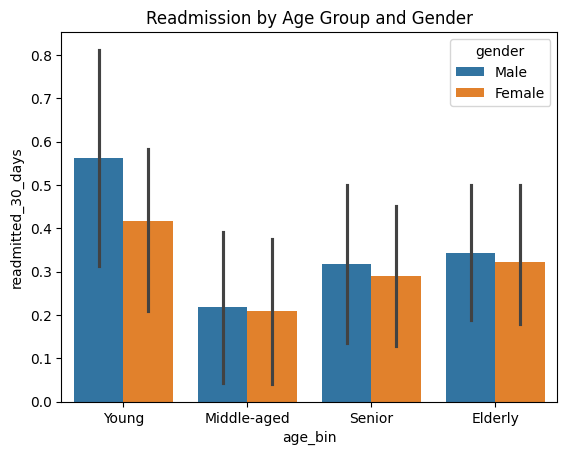

In [14]:
# Age + Gender effect on readmissions
sns.barplot(data=df_task1, x='age_bin', y='readmitted_30_days', hue='gender')
plt.title("Readmission by Age Group and Gender")
plt.show()


Across all age groups, males have higher readmissions as compared to females

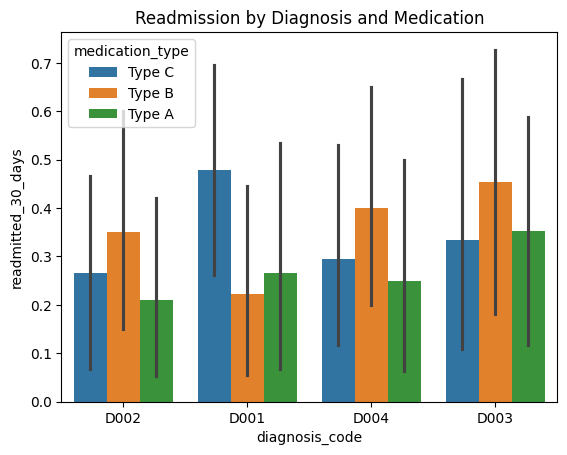

In [15]:
# Diagnosis + Medication effect on readmissions
sns.barplot(data=df_task1, x='diagnosis_code', y='readmitted_30_days', hue='medication_type')
plt.title("Readmission by Diagnosis and Medication")
plt.show()

Patients with Type B across all the given diagnosis have high readmissions except for Diagnosis - D001 which shows patients with Type C medication with high readmissions

I applied one-hot encoding for the categorical columns

In [16]:
df_encoded = pd.get_dummies(df_task1, columns=['gender', 'diagnosis_code', 'medication_type', 'age_bin'], drop_first=True)
df_encoded.head()

,num_previous_admissions,length_of_stay,readmitted_30_days,stay_per_admission,gender_Male,diagnosis_code_D002,diagnosis_code_D003,diagnosis_code_D004,medication_type_Type B,medication_type_Type C,age_bin_Middle-aged,age_bin_Senior,age_bin_Elderly
0,3,2,0,0.666667,True,True,False,False,False,True,False,False,True
1,1,3,1,3.000000,False,True,False,False,True,False,True,False,False
2,2,5,1,2.500000,True,True,False,False,False,True,False,False,True
3,2,11,0,5.500000,False,True,False,False,False,True,True,False,False
4,1,8,1,8.000000,False,False,False,False,False,True,True,False,False


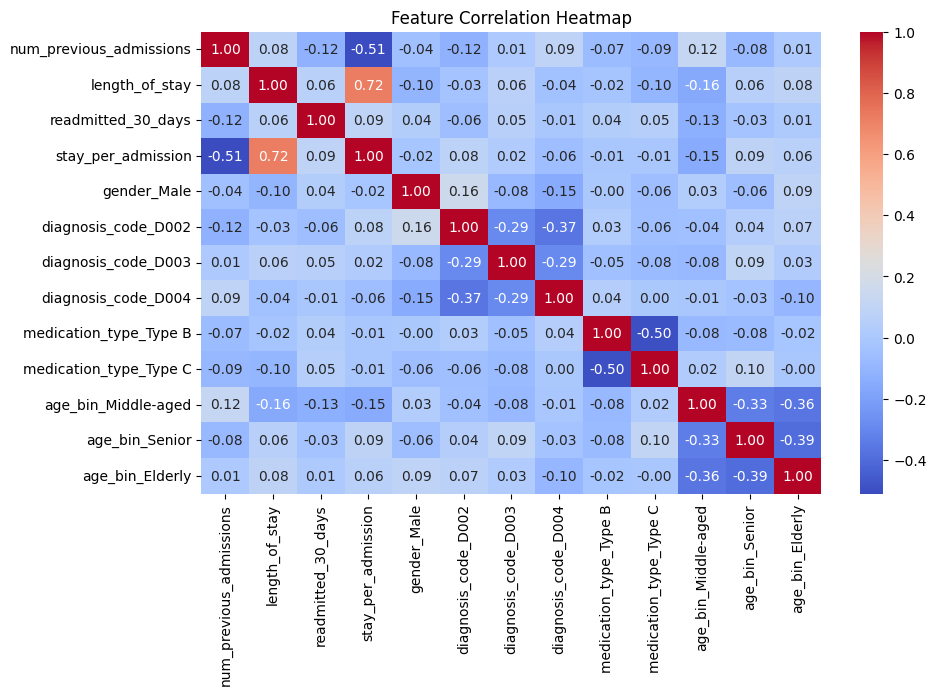

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Before model training, we need to check whether there is an imabalnce in the target column to ensure that our model can accurately predict

readmitted_30_days
0    135
1     65
Name: count, dtype: int64


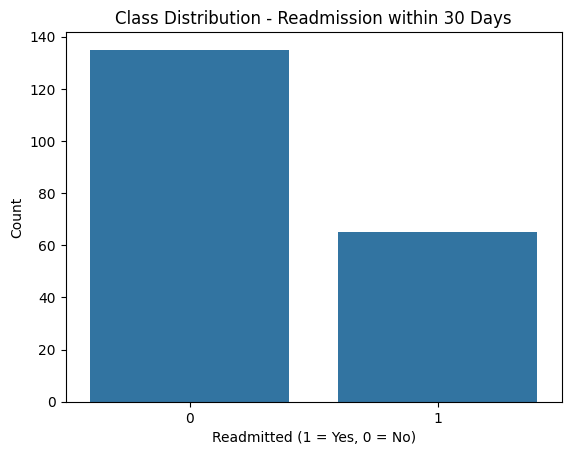

In [18]:
class_counts = df_encoded['readmitted_30_days'].value_counts()
print(class_counts)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution - Readmission within 30 Days")
plt.xlabel("Readmitted (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

As we can see, the dataset is imbalanced with roughly 135 “No” vs 65 “Yes” cases. We’ll handle this using SMOTE (Synthetic Minority Oversampling Technique) which creates synthetic samples of the minority class to balance the dataset. This prevents the model from being biased toward the majority (non-readmitted) class and helps improve recall for patients likely to be readmitted.

Split the dataset into train and test with 80-20 split

In [19]:
from sklearn.model_selection import train_test_split

# Split data
X = df_encoded.drop('readmitted_30_days', axis=1)
y = df_encoded['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We apply SMOTE only on training data to avoid data leakage

In [20]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [108  52]
After SMOTE: [108 108]


To predict if patient has to readmit within 30 days, we use the follwoing models and select model with best performance:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

We use ROC_AUC and F1 Score for evalutaion to select the best model that can balance both precision and recall

#### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

# Scale numeric columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()

X_train_res_scaled = X_train_res.copy()
X_test_scaled = X_test.copy()

X_train_res_scaled[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res_scaled, y_train_res)
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Logistic Regression Results:")
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Results:
ROC AUC: 0.396011396011396
F1 Score: 0.3333333333333333
Confusion Matrix:
 [[15 12]
 [ 8  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60        27
           1       0.29      0.38      0.33        13

    accuracy                           0.50        40
   macro avg       0.47      0.47      0.47        40
weighted avg       0.54      0.50      0.51        40



#### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Results:
ROC AUC: 0.621082621082621
F1 Score: 0.5
Confusion Matrix:
 [[19  8]
 [ 6  7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        27
           1       0.47      0.54      0.50        13

    accuracy                           0.65        40
   macro avg       0.61      0.62      0.62        40
weighted avg       0.66      0.65      0.66        40



#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Results:
ROC AUC: 0.3433048433048433
F1 Score: 0.09523809523809523
Confusion Matrix:
 [[20  7]
 [12  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.74      0.68        27
           1       0.12      0.08      0.10        13

    accuracy                           0.53        40
   macro avg       0.38      0.41      0.39        40
weighted avg       0.46      0.53      0.49        40



#### XGBoost

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=20, max_depth=10, random_state=42, eval_metric='auc')
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Results:
ROC AUC: 0.4415954415954416
F1 Score: 0.19047619047619047
Confusion Matrix:
 [[21  6]
 [11  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71        27
           1       0.25      0.15      0.19        13

    accuracy                           0.57        40
   macro avg       0.45      0.47      0.45        40
weighted avg       0.52      0.57      0.54        40



Out of these 4 models, Decision Tree performs the best balancing both ROC_AUC and F1 Score.

The Decision Tree model performed best because the dataset is relatively small, categorical, and non-linear, where simple models capture patterns more effectively than complex ensembles.

Unlike Logistic Regression, Decision tree can handle nonlinear relationships and categorical splits natively. Compared to Random Forest and XGBoost, the Decision Tree avoids overfitting synthetic SMOTE samples and instability from small-sample ensembles.

Its rule-based interpretability also aligns naturally with the clinical decision-making process, making it both the most logical and practical model for this task.

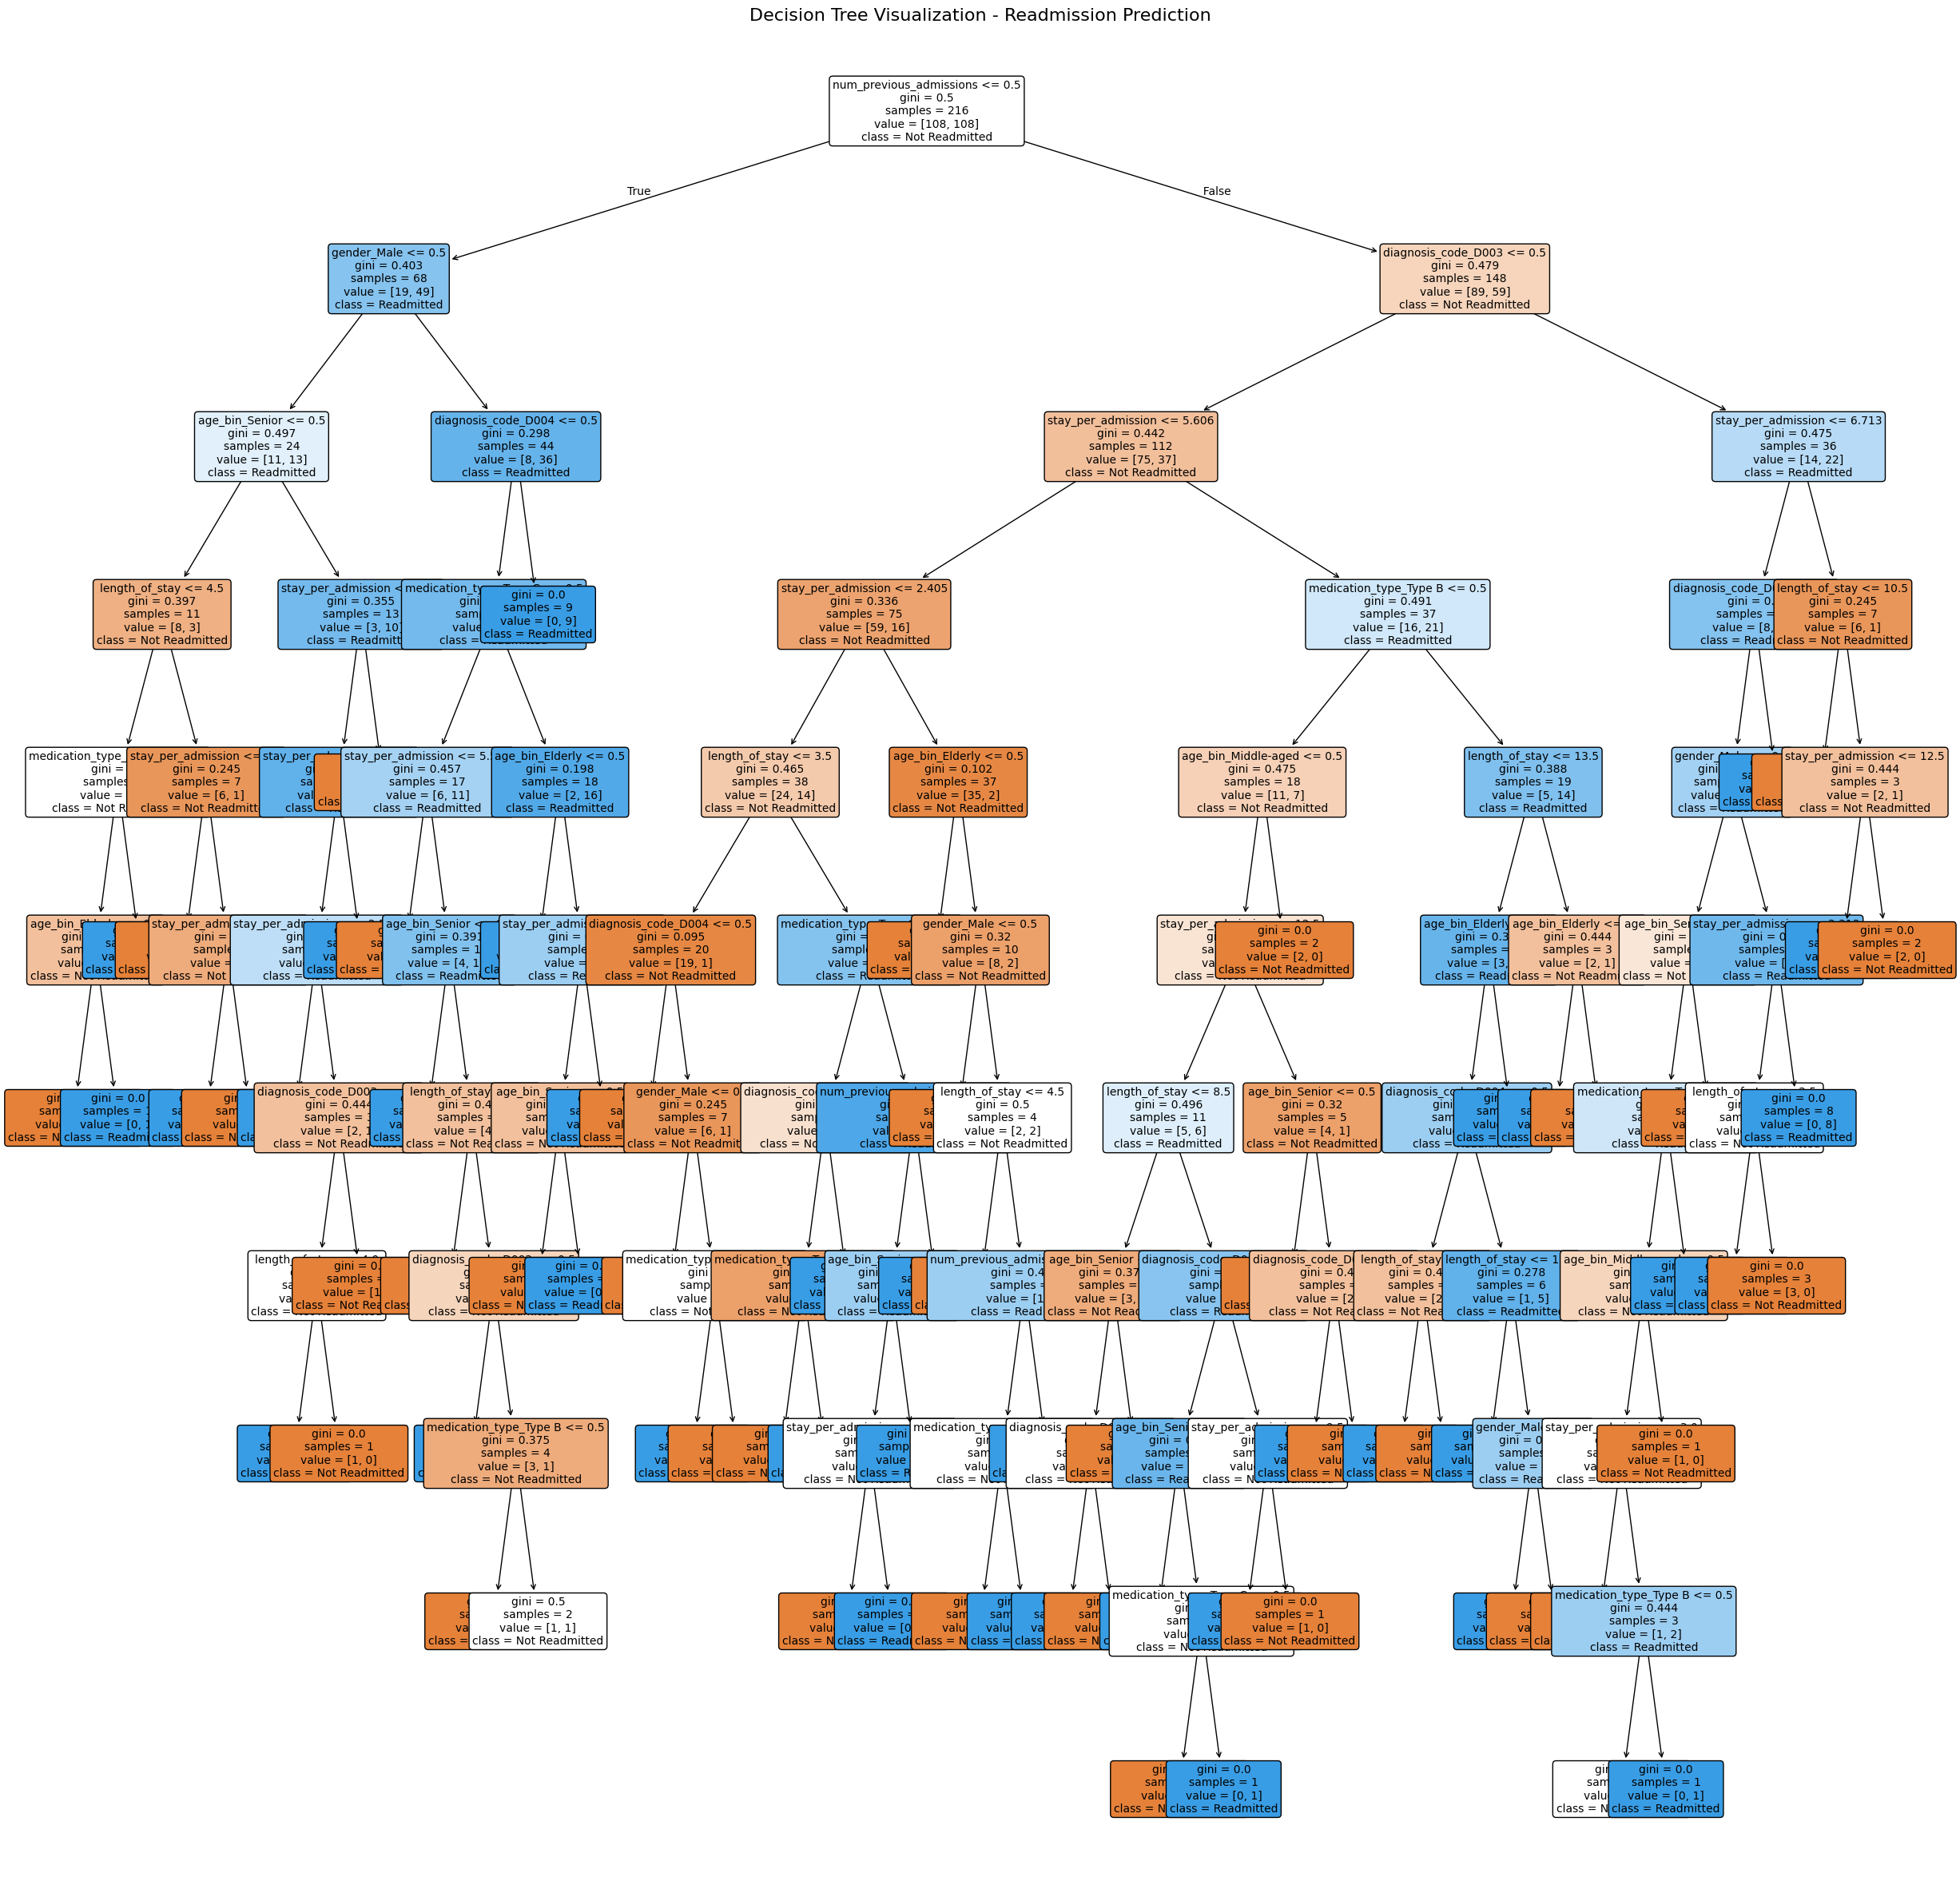

In [25]:
plt.figure(figsize=(30,30))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Not Readmitted", "Readmitted"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization - Readmission Prediction", fontsize=16)
plt.show()

/tmp/ipython-input-1644175150.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


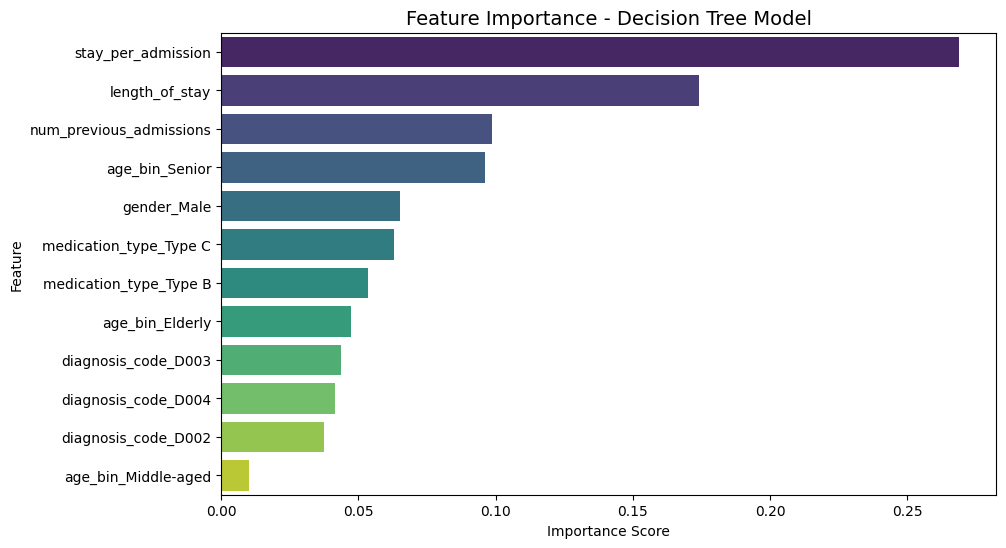

In [26]:
# Get feature importances
importances = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Feature Importance - Decision Tree Model", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

stay_per_admission, length_of_stay, num_previous_admissions, age_bin_senior, gender_male are the most influential features for predicting whether a patient will be readmitted within 30 days.

Patients who are older, have a history of frequent or prolonged hospitalizations, and exhibit longer stays per admission are at higher risk of being readmitted within 30 days

### Task 2 - Extracts and categorises key information from free-text discharge notes

In this task, The aim is to turn discharge notes into structured information. This helps us to understand patients diagnosis, symptoms, treatments, medications and follow-up instructions in organized way.

For this, we do this in two main steps: first extracting relevant entities, then categorizing them.

In [ ]:
!pip install transformers torch openai pandas

In [1]:
import pandas as pd
from transformers import pipeline
import openai
import json
import re

In [2]:
df = pd.read_excel("Assignment_Data.xlsx")
discharge_notes = df['discharge_note'].tolist()

#### Named Entity Extraction Using Flan-T5

The first step is to pull out named or medical entities from the notes. These could be "pneumonia", "minor discomfort", "antibiotics", "post-surgery care"
or "follow-up in 2 weeks"

I used Flan-T5 for this instead of traditional tools like spaCy or BART because flan-t5 is instruction-tuned, which means it can understand complex prompts and can implicit information of clinical language. SpaCy is rule-based and might miss subtle meanings, while BART performs similar to flan-t5 but needs fine-tuning.

In [3]:
extractor = pipeline(
    "text2text-generation",
    model="google/flan-t5-large"
)

def extract_entities_flan(note):
    prompt = f"""
You are a clinical information extraction assistant.
Extract all medical entities, conditions, interventions, medications, symptoms, and follow-up instructions from the discharge note.
Include explicit and implicit info, even negated conditions (e.g., "no complications").
Return as a **list of phrases**, one per line, without categorization.

Discharge Note:
{note}
"""
    result = extractor(prompt, max_length=256)
    phrases = result[0]['generated_text'].split('\n')
    phrases = [p.strip() for p in phrases if p.strip()]
    return phrases

Device set to use cuda:0


#### Categorizing Entities Using GPT
We have extracted the medical entities using Flan-T5 and the next step is to organize them into five categories - Diagnosis, Symptoms, Treatments, Medications and Follow-up

Here I used GPT-4 for this because it can understand subtle differences between categories and preserve the exact wording of the phrases. For example, it can tell that "recovery from pneumonia" is related to diagnosis or follow-up, while "antibiotics for 5 days" is a medication.

By separating extraction and categorization, this pipeline is modular and easier to debug.

In [4]:
client = openai.OpenAI(api_key="YOUR_OPENAI_API_KEY")
def categorize_entities_gpt(phrases):
    phrases_text = "\n".join(phrases)
    prompt = f"""
You are a medical assistant.
Categorize the following clinical entities or phrases into Diagnosis, Symptoms, Treatments, Medications, Follow_up.
Return a JSON object with exactly these five keys.
Maintain original wording. Use empty lists if no phrases belong to a category.

Extracted Phrases:
{phrases_text}
"""
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    gpt_output = response.choices[0].message.content
    cleaned_output = re.sub(r"```(json)?", "", gpt_output).strip()
    # print(cleaned_output)
    try:
        json_output = json.loads(cleaned_output)
    except:
        json_output = {"Diagnosis": [], "Symptoms": [], "Treatments": [], "Medications": [], "Follow_up": []}
    return json_output

In [5]:
# Run pipeline on all discharge notes
results = []

for note in discharge_notes:
    entities = extract_entities_flan(note)
    categorized = categorize_entities_gpt(entities)
    results.append(categorized)
results_df = pd.DataFrame(results)
results_df['discharge_note'] = discharge_notes


results_df.to_csv("discharge_notes_entities_categorized.csv", index=False)
print("Results saved to discharge_notes_entities_categorized.csv")

Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Results saved to discharge_notes_entities_categorized.csv


In [6]:
results_df.head()

,Diagnosis,Symptoms,Treatments,Medications,Follow_up,discharge_note
0,[],[],[],[],[Follow-up scan scheduled next month],Good recovery trajectory. Follow-up scan sched...
1,[],[],[avoid physical exertion],[],[post-surgery],Stable post-surgery. Advised to avoid physical...
2,[],[symptom],[],[],[monitoring for relapse],Symptoms controlled. Monitoring for relapse ad...
3,[],[],[avoid physical exertion],[],[post-surgery],Stable post-surgery. Advised to avoid physical...
4,[],[],[avoid physical exertion],[],[post-surgery],Stable post-surgery. Advised to avoid physical...


As we can see from the results that this appraoch was able to extract the entities and properly categorize them.

Even though this approach is powerful, there are few risks and limitations:

- Hallucination: The models sometimes generate information not in the note.
- Entity Ambiguity: Some phrases could belong to multiple categories depending on context and the model finds it hard to decide which category should that entity belong to.
- General-Purpose Models: Flan-T5 and GPT-4 are not medically certified, so their outputs need review or we can use pre-trained medical variant models
- Negations & Implicit Info: Statements like "no complications" need careful handling to avoid misclassification.
- Data Privacy: Discharge notes are sensitive and we should handle them according to privacy regulations like HIPAA.

Keeping these limitations in mind, this pipeline is useful for rapid prototyping and extracting structured data from clinical notes, as long as human oversight is maintained.